Goal: Sample from the posterior distribution (for Thompson sampling).

Step 1: mental model: Prior and data --> Posterior. Posterior is similar to $\hat\theta$ frequentist estimate (e.g., RF, NN, XGBoost).

Step 2: Approximate he sample distribution of $\hat\theta$ through Generalized boostrapping. One option would be to bootstrap the data, and fit multiple models $\hat\theta_1, \hat\theta_2, ...$  But we only need a single sample. This is how we get it a single sample.

In [1]:
from collections import Counter
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error
import xgboost as xgb

diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
n_obs = X_train.shape[0]

print("Bootstrapping...")
sample_weight = np.random.exponential(size=n_obs)
sample_idx = np.random.choice(np.arange(n_obs), size=n_obs, p = sample_weight / sample_weight.sum())
X_train_boot = X_train[sample_idx,:]
y_train_boot = y_train[sample_idx]

n_uniq_boot = len(set(sample_idx))
print(f"Unique bootstrapped samples: {n_uniq_boot} ({n_uniq_boot/n_obs:.1%})")

# Train 
dtrain = xgb.DMatrix(X_train, y_train)
param = {"objective": "reg:squarederror"}
model = xgb.train(param, dtrain, num_boost_round=10)

# Train Bootstrapped
dtrain_boot = xgb.DMatrix(X_train_boot, y_train_boot)
param = {"objective": "reg:squarederror"}
model_boot = xgb.train(param, dtrain_boot, num_boost_round=10)

# Evaluate
dtest = xgb.DMatrix(X_test, y_test)
predictions = model.predict(dtest)
print(f"rmse = {sqrt(mean_squared_error(y_test, predictions)):.2f}")

# Evaluate bootstrapped
predictions_boot = model_boot.predict(dtest)
print(f"rmse = {sqrt(mean_squared_error(y_test, predictions_boot)):.2f} (bootstrapped)")

Bootstrapping...
Unique bootstrapped samples: 170 (51.4%)
rmse = 69.20
rmse = 65.35 (bootstrapped)


Text(0, 0.5, 'Exploration Ratio (%)')

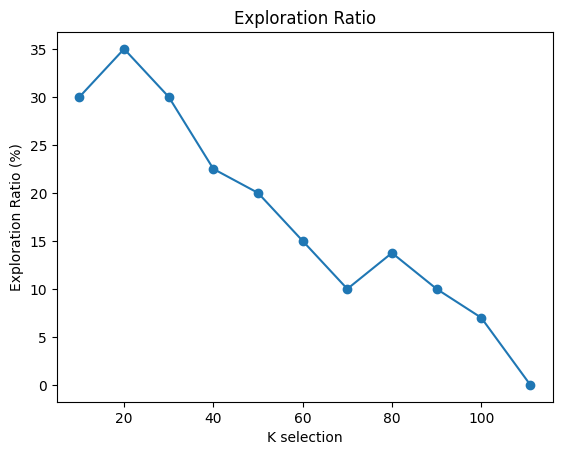

In [2]:
k_options = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 111]
exploration_ratios = []
k_selection = 10
n_candidates = len(predictions)

for k_selection in k_options:
    selected_items = np.argsort(predictions)[-k_selection:]
    selected_items_boot = np.argsort(predictions_boot)[-k_selection:]
    explored_items = set(selected_items) - set(selected_items_boot)
    exploration_ratio = len(explored_items) / k_selection
    exploration_ratios.append(exploration_ratio * 100)

plt.plot(k_options, exploration_ratios, marker="o")
plt.title("Exploration Ratio")
plt.xlabel("K selection")
plt.ylabel("Exploration Ratio (%)")

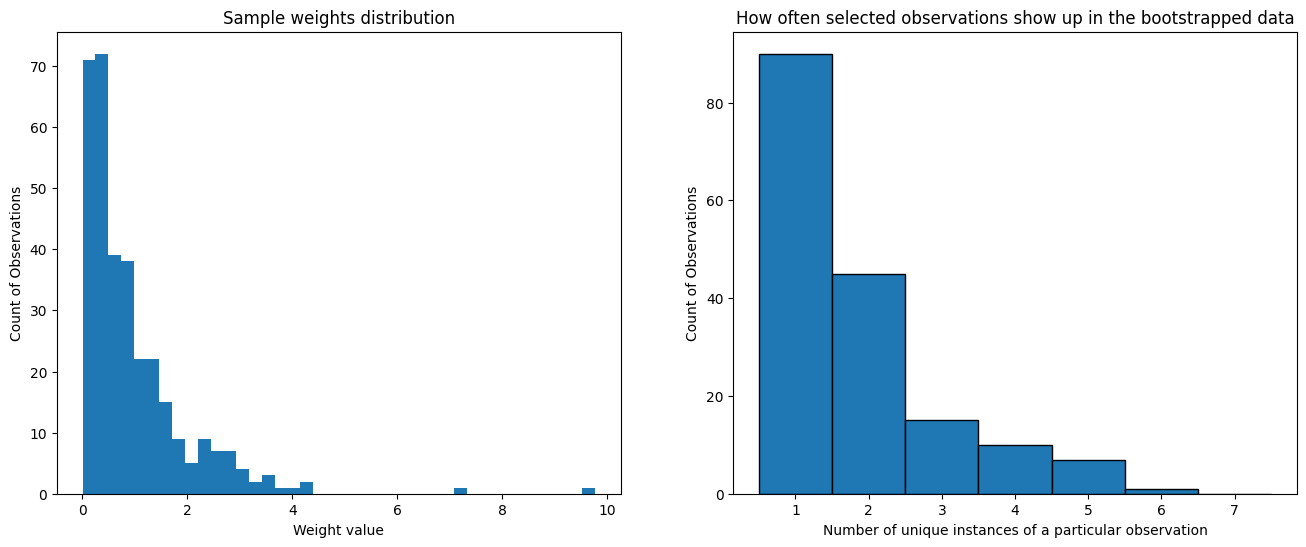

In [3]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

ax[0].hist(sample_weight, bins=40)
ax[0].set_title("Sample weights distribution")
ax[0].set_xlabel("Weight value")
ax[0].set_ylabel("Count of Observations")

frequencies = Counter(sample_idx).values()
frequencies = np.array([val for val in frequencies])
ax[1].hist(frequencies, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5], edgecolor="k")
ax[1].set_xlabel("Number of unique instances of a particular observation")
ax[1].set_ylabel("Count of Observations")
_ = ax[1].set_title("How often selected observations show up in the bootstrapped data")

For the second chart, ~80 of the observations show up once, ~40 show up twice, etc...